<a href="https://colab.research.google.com/github/shreyab1111/MultiLexNorm-Challenge/blob/main/Italian/it_ln_seq2seq_biLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate
from tensorflow.keras import Input, Model

German

In [5]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 128  # Latent dimensionality of the encoding space.
num_samples = 30000  # Number of samples to train on.
data_path = '/content/drive/MyDrive/NLP/Lexical Normalisation/Multilexnorm Challenge/Italian/it.train.norm.txt'

Character encoding

In [6]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r") as f:
    lines = f.readlines()
for line in lines[: min(num_samples, len(lines) - 1)]:
  if line=='\n':
    continue
  else:
    input_text, target_text= line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 12645
Number of unique input tokens: 133
Number of unique output tokens: 134
Max sequence length for inputs: 56
Max sequence length for outputs: 59


In [7]:
input_texts

['STO',
 'MALE',
 ':c',
 '#rt',
 'seguimi',
 'ti',
 'seguo',
 'e',
 'ti',
 'faccio',
 'una',
 'domanda',
 '..',
 'mi',
 'annoio',
 ':c',
 '#follow',
 '#followme',
 'x9',
 'Crosetto',
 ':',
 '"',
 'Monti',
 'trovi',
 'soluzioni',
 'reali',
 '"',
 ':',
 '#governo',
 '#guido',
 'crosetto',
 '#mario',
 'monti',
 'ROMA',
 '–',
 "''",
 'Occorre',
 'permettere',
 'a',
 'que...',
 'http://t.co/9ibXLgRf',
 'Ho',
 'appena',
 'acquistato',
 'Ballerina',
 'Necklace',
 'su',
 'Stardoll',
 '.',
 'Dai',
 "un'",
 'occhiata',
 'alla',
 'mia',
 'Suite',
 '!',
 'http://t.co/4izCbBod',
 'Crisi',
 ',',
 'Fitch',
 ':',
 'tagli',
 'più',
 'severi',
 'evitati',
 'grazie',
 'a',
 'governo',
 'Monti',
 ':',
 'New',
 'York',
 ',',
 '27',
 'gen',
 '.',
 '(',
 'TMNews',
 ')',
 '?',
 '"',
 "Un'",
 'azione',
 'più',
 'sever...',
 'http://t.co/noUM2hJi',
 '-',
 'Mamma',
 'domani',
 'torno',
 '.',
 'Che',
 'clima',
 "c'",
 'è',
 'a',
 'Roma',
 '?',
 'Fa',
 'così',
 'caldo',
 '?',
 '-',
 'Mah',
 '.',
 'È',
 'un',
 'aut

encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.

decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the French sentences.

decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].

In [8]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

one hot rep

In [9]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[',']] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, (t + 1):, target_token_index[',']] = 1.0
    decoder_target_data[i, t:, target_token_index[',']] = 1.0

In [10]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = encoder(encoder_inputs)

state_h = Concatenate()([forw_state_h, back_state_h])
state_c = Concatenate()([forw_state_c, back_state_c])

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM((2*latent_dim), return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [11]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Epoch 1/100
159/159 [==============================] - 21s 70ms/step - loss: 0.4624 - accuracy: 0.8972 - val_loss: 0.5257 - val_accuracy: 0.8411
Epoch 2/100
159/159 [==============================] - 9s 58ms/step - loss: 0.2671 - accuracy: 0.9309 - val_loss: 0.2611 - val_accuracy: 0.9314
Epoch 3/100
159/159 [==============================] - 9s 58ms/step - loss: 0.1915 - accuracy: 0.9506 - val_loss: 0.1854 - val_accuracy: 0.9507
Epoch 4/100
159/159 [==============================] - 9s 59ms/step - loss: 0.1375 - accuracy: 0.9640 - val_loss: 0.1242 - val_accuracy: 0.9666
Epoch 5/100
159/159 [==============================] - 9s 59ms/step - loss: 0.1012 - accuracy: 0.9734 - val_loss: 0.1053 - val_accuracy: 0.9732
Epoch 6/100
159/159 [==============================] - 9s 58ms/step - loss: 0.0766 - accuracy: 0.9806 - val_loss: 0.1439 - val_accuracy: 0.9647
Epoch 7/100
159/159 [==============================] - 9s 58ms/step - loss: 0.0600 - accuracy: 0.9850 - val_loss: 0.1034 - val_accuracy

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


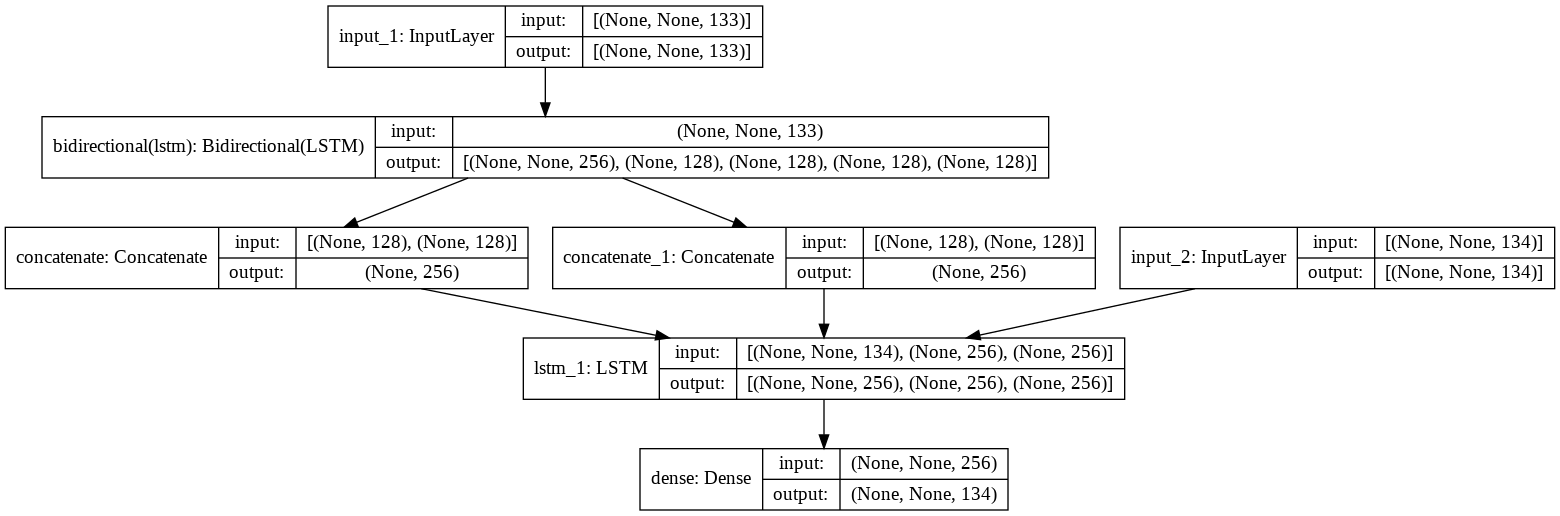

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

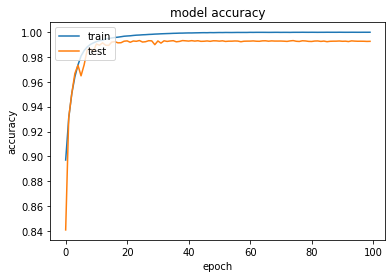

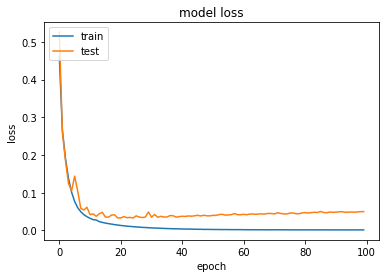

In [13]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

testing with validation

In [14]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = model.layers[1].output # lstm_1
state_h_enc = Concatenate()([forw_state_h, back_state_h])
state_c_enc = Concatenate()([forw_state_c, back_state_c])
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=((2*latent_dim),), name="input_7")
decoder_state_input_c = keras.Input(shape=((2*latent_dim),), name="input_5")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[5]
initial_state=decoder_states_inputs
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, initial_state=initial_state)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [15]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: STO
Decoded sentence: sto

-
Input sentence: MALE
Decoded sentence: male

-
Input sentence: :c
Decoded sentence: :c

-
Input sentence: #rt
Decoded sentence: #rt

-
Input sentence: seguimi
Decoded sentence: seguimi

-
Input sentence: ti
Decoded sentence: ti

-
Input sentence: seguo
Decoded sentence: seguo

-
Input sentence: e
Decoded sentence: e

-
Input sentence: ti
Decoded sentence: ti

-
Input sentence: faccio
Decoded sentence: faccio

-
Input sentence: una
Decoded sentence: una

-
Input sentence: domanda
Decoded sentence: domanda

-
Input sentence: ..
Decoded sentence: ..

-
Input sentence: mi
Decoded sentence: mi

-
Input sentence: annoio
Decoded sentence: annoio

-
Input sentence: :c
Decoded sentence: :c

-
Input sentence: #follow
Decoded sentence: #follow

-
Input sentence: #followme
Decoded sentence: #followme

-
Input sentence: x9
Decoded sentence: x9

-
Input sentence: Crosetto
Decoded sentence: Crosetto

-
Input sentence: :
Decoded sentence: :

-
Input sente